In [0]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

In [0]:
# Seed random number generator - for reproducibility
np.random.seed(42)

In [0]:
def ecdf(data):
    """Compute Empirical Cumulative Distribution Function for
    a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y
  
# The y data of the ECDF go from 1/n to 1 in equally spaced increments
# end value in np.arange() is not inclusive: np.arange() will range from 1 to n+1

## Normal Distribution

Probability Density Function (PDF) is the **continuous** analog to the probability mass function (PMF). It describes the chances of observing a value of a continuous variable (ex: the speed of light). We can extract probabilities by knowing the area under the PDF. **Normal distribution** describes a continuous variable whose PDF is symmetric and has a single peak. ND has two parameters: **mean** and **standard deviation**. The mean determines where the center of the peak is, while the std is the measure of how wide the peak is or how spread out the data is. See more [here](https://towardsdatascience.com/understanding-the-68-95-99-7-rule-for-a-normal-distribution-b7b7cbf760c2).

The quickest way to know if our data is normally distributed (obeys ND) is to plot the CDF of the data against the CDF of the ND and then compare them(comparing the pdf can suffer from the binning bias). We then can plot the theoretical CDF and empirical CDF (ECDF) on the same plot to compare. We can draw as many samples out of the ND as we want. If our data has some outliers (rare instances) that are important, we shall increase the number of samples of the ND to make the bell curve wider and see if those samples' CDF aligns with the CDF of our data.

Quick note: the mean & std of the ND are different than the mean and the std of the actual data (derived from the eda)! These are just parameters for the ND.

Quick note 2: Normal distribution is also referred to as Gaussian distribution. Its caveat is: often times things we may think are Normally distributed are not. Thus we need to plt the compare (plot) the CDF against the ECDF to make sure the data is normally distributed. We might be making too big of an error by treating it as so.

Quick note3: for data that is Normally distributed, the probability of a data point being far more than four standard deviations from the mean is very small (check the ND graph), so for a real life data that has a lot of of extreme values (outliers), ND is not the best option to represent our data.

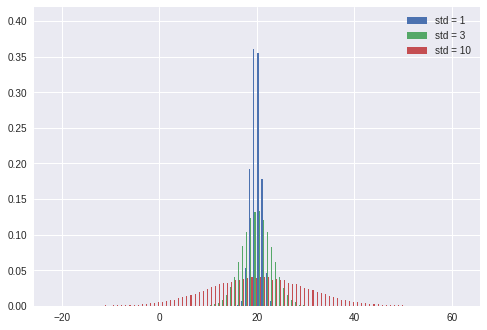

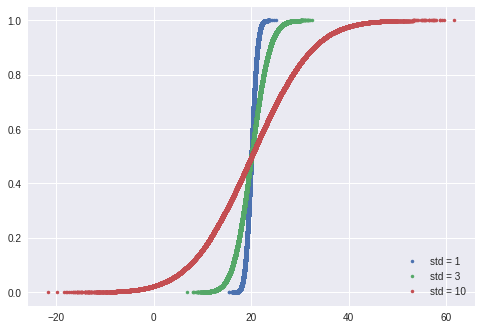

In [81]:
# PDF example: draw 100000 samples from Normal distribution with different stds
samples_std1 = np.random.normal(20,1,100000)
samples_std3 = np.random.normal(20,3,100000)
samples_std10 = np.random.normal(20,10,100000)

# Plot PDFs
plt.hist([samples_std1, samples_std3, samples_std10], density=True, bins=100)
plt.legend(('std = 1', 'std = 3', 'std = 10'))
plt.ylim(0, 0.42)
plt.show()

# Generate the corresponding CDFs
x_std1, y_std1 = ecdf(samples_std1)
x_std3, y_std3 = ecdf(samples_std3)
x_std10, y_std10 = ecdf(samples_std10)

# Plot CDFs
plt.plot(x_std1, y_std1, marker='.', linestyle='none')
plt.plot(x_std3, y_std3, marker='.', linestyle='none')
plt.plot(x_std10, y_std10, marker='.', linestyle='none')
plt.legend(('std = 1', 'std = 3', 'std = 10'), loc='lower right')
plt.show()

From the prevoius plot, we can deduce that:
1. All the CDFs pass through the mean @the 50th percentile. i.e the mean and the median of a ND are the same.
2. The width of the CDF varies with the standard deviation.

Now let's apply his on some real data. The Belmont Stakes is a 1.5 mile-long race of thoroughbred horses. It's been happening yearly since 1867. What we would like to do is scrape wikipedia for the [Belmont Stakes](https://en.wikipedia.org/wiki/Belmont_Stakes) race timings and plot their **ECDF** against their **theoretical CDF** to check if these race timings are **Normally distributed**. We are going to only use the race timings of the years from 1926 to 2018. 1973 witnessed the fastest Belmont Stakes in history, while 1970 was the slowest because of unusually wet and sloppy conditions. So, we will remove these two outliers.

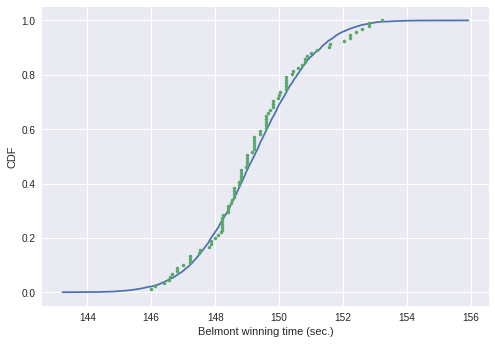

In [71]:
# Scrape Wikipedia for the Belmont Stakes
website_url = requests.get('https://en.wikipedia.org/wiki/Belmont_Stakes').text
soup = BeautifulSoup(website_url,'lxml')
my_table = soup.find('table',{'class':'wikitable sortable'})
links = my_table.findAll('td')

# Create an empty list to store race times
race_time = []
for link in links:
  # Extract race times: search by the needed time format - 2:28.18
  if(re.match(r"([0-9]:[0-9]{2}\.[0-9]{2})", link.text)):
    race_time.append(re.match(r"([0-9]:[0-9]{2}\.[0-9]{2})", link.text).group(1))

race_time = np.array(race_time)

# Post-processing: convert time to seconds
for t in range(len(race_time)):
  race_time[t] = float(str(race_time[t])[0]) * 60 + float(str(race_time[t])[-5:])

race_time = race_time.astype(np.float)

# Include only the races from 1926 to 2018 and remove outliers
race_time = race_time[:93]
outliers = [np.argmin(race_time), np.argmax(race_time)]
race_time = np.delete(race_time, outliers)

# Compute mean and standard deviation - mu & sigma of race timings
mu = np.mean(race_time)
sigma = np.std(race_time)

# Sample out of a normal distribution with the same mu and sigma
samples = np.random.normal(mu, sigma, size=10000) # sample size=10000

# Get the CDF of the ND samples and of the data
x_theor, y_theor = ecdf(samples) # theoretical CDF
x, y = ecdf(race_time) # empirical CDF

# Plot CDFs
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Belmont winning time (sec.)')
plt.ylabel('CDF')
plt.show()

The theoretical CDF and the ECDF of the data suggest that the winning Belmont times are, indeed, **Normally distributed**. This also suggests that in the last 100 years or so, there have not been major technological or training advances that have significantly affected the speed at which horses can run this race (relatively same speed).

Now knowing that at 1970, the horse named Secretariat has scored the best all-time record of 144 seconds, we would like to know what is the probability of a winner beating that score.

In [75]:
# Take a million samples out of the Normal distribution
samples = np.random.normal(mu, sigma, size=1000000)

# Compute the fraction that are faster than 144 seconds
prob = np.sum(samples <= 144)/len(samples)

# Print the result
print('Probability of beating the best all-time record:', prob)

Probability of beating the best all-time record: 0.000563


## Exponential Distribution

Exponential distribution can be used to describe the waiting time between arrivals in a Poisson process (between rare events). It only has  single parameter: the **mean waiting time**. An example for this is: the time between all incidents involving nuclear power since 1974 (we can expect this to be a Poisson process because the timing of one incident is independent of all others).

Quick note: the Normal and Exponential distributions are just two of many examples of continuous distributions.

In [0]:
def successive_poisson(tau1, tau2, size=1):
    """Compute time for arrival of 2 successive Poisson processes."""
    
    # Draw samples out of the first exponential distribution
    t1 = np.random.exponential(tau1, size)

    # Draw samples out of the second exponential distribution
    t2 = np.random.exponential(tau2, size)

    return t1 + t2

Sometimes, the story describing our probability distribution does not have a named distribution to go along with it. In these cases, we can always simulate it. Now, we would like to know what is the total waiting time for the arrival of two different Poisson processes. The total waiting time is the time waited for the first rare event plus the time waited for the second rare event. The above `successive_poisson` function is to sample out of the distribution described by this story.

Now, we would like to use our function to compute the total waiting time for two rare events: the first with a mean waiting time of 764 and the second 715.

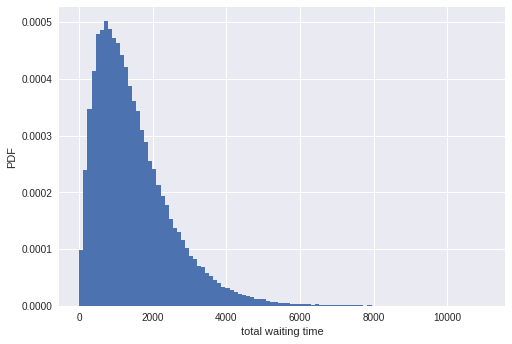

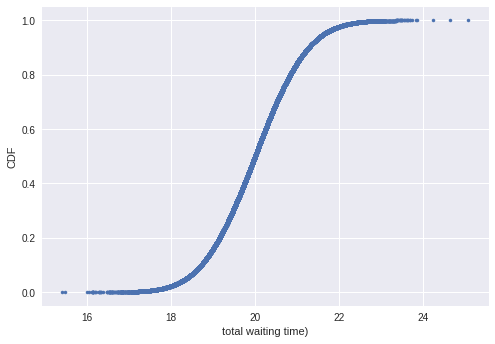

In [82]:
# Draw samples of waiting times
waiting_times = successive_poisson(764, 715, size=100000)

# Plot the PDF
plt.hist(waiting_times, bins=100, density=True)
plt.xlabel('total waiting time')
plt.ylabel('PDF')
plt.show()

# Generate the CDF
x, y = ecdf(waiting_times)

# Plot the CDF
plt.plot(x_std1, y_std1, marker='.', linestyle='none')
plt.xlabel('total waiting time)')
plt.ylabel('CDF')
plt.show()